In [1]:
import keras
keras.__version__

/Users/rchase/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.3'

In [2]:
import sys
print (sys.version)

3.6.1 |Anaconda custom (64-bit)| (default, May 11 2017, 13:04:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


# Using a pre-trained convnet

This notebook contains the code sample found in Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original 
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task. For instance, one might train a network on 
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as 
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning 
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat 
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture 
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent 
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing 
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, 
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with 
feature extraction.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the 
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer 
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of 
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the 
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are 
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional 
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the 
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more 
general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [4]:
# set base dir
base_dir = '/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/'

In [6]:
import matplotlib.pyplot as plt

In [11]:
# import packages
import numpy as np
import os, sys
from glob import glob
from shutil import copyfile

# copy some files to from validation to test 
# (RC: should these be completely unseen, though rather than copying from valid? Even though valid isn't used to train...)
valid_dir_for_class = os.path.join(base_dir, 'Images/architecture_styles/valid/Denver_Squares/')

os.chdir(valid_dir_for_class)
# os.getcwd()
# match files in the current working directory
g = glob('*.jpg')
shuf = np.random.permutation(g)
# RC: this isn't working.  The glob object is an empty list and we're trying to do a random permutation of it which wouldn't make sense. 
for i in range(10): copyfile(valid_dir_for_class + shuf[i], base_dir+'Images/architecture_styles/test/hidden_classes/' + shuf[i])

In [12]:
# import the VGG16 pretrained model
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  # do not include the top, fully-connected Dense layers (there are 3 fully-connected layers in VGG16)
                  include_top=False,
                  input_shape=(150, 150, 3))

We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (with only two classes, cat and dog), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size.

Here's the detail of the architecture of the VGG16 convolutional base: it's very similar to the simple convnets that you are already 
familiar with.

In [13]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

The final feature map has shape `(4, 4, 512)`. That's the feature on top of which we will stick a densely-connected classifier.

At this point, there are two ways we could proceed: 

* Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a 
standalone densely-connected classifier similar to those you have seen in the first chapters of this book. This solution is very fast and 
cheap to run, because it only requires running the convolutional base once for every input image, and the convolutional base is by far the 
most expensive part of the pipeline. However, for the exact same reason, this technique would not allow us to leverage data augmentation at 
all.
* Extending the model we have (`conv_base`) by adding `Dense` layers on top, and running the whole thing end-to-end on the input data. This 
allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. 
However, for this same reason, this technique is far more expensive than the first one.

We will cover both techniques. Let's walk through the code required to set-up the first one: recording the output of `conv_base` on our 
data and using these outputs as inputs to a new model.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [90]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

train_dir = os.path.join(base_dir, 'Images/architecture_styles/train/')
validation_dir = os.path.join(base_dir, 'Images/architecture_styles/valid/')
test_dir = os.path.join(base_dir, 'Images/architecture_styles/test/')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# extract features of my images using the VGG16 pre-trained model
def extract_features(directory, sample_count):
    # the output of VGG16's convolutional base produces filter maps of shape (sample_count, 4, 4, 512)
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    # make the shape of the second dimension of the label array 3 to account for our three classes
    labels = np.zeros(shape=(sample_count,3))
    # use flow_from_directory to take images from the training directory, re-size them, and create batches
    generator = datagen.flow_from_directory( 
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        # RC: set class_mode=categorical for 2D one-hot encoded labels (best for multi-class, as opposed to binary, sparse labels, etc.) 
        # https://keras.io/preprocessing/image/
        class_mode='categorical')
    # define the label map outside of the function
    global label_map 
    # populate label map (if class_mode='categorical' this will be our 2D one-hot encoded array)
    label_map = generator.class_indices
    
    # RC: define RC_raw_images outside of the function
    if directory[-5:-1]=='test':
        # RC: Here I'm setting up an array for the the raw images to flow into - I made the dimensions of each of the images 150 x 150. 
        RC_raw_test_images = np.zeros(shape=(sample_count, 150, 150, 3))
        
    
    i = 0
    for inputs_batch, labels_batch in generator:
        #print(type(inputs_batch[0]))
        # print(inputs_batch)
        
        #RC: first I'm saving the raw images
        if directory[-5:-1]=='test':
            RC_raw_test_images[i * batch_size : (i + 1) * batch_size] = inputs_batch
        
        # use the .predict method to extract the features from the pre-trained model "conv_base"
        features_batch = conv_base.predict(inputs_batch)
        #print(features_batch.shape)
        #print(type(features_batch))
        #print(features_batch)
        # save the result in the array we created above
        #RC:REVIEW!
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        #print(features.shape)
        #print(type(features))
        # print(labels_batch.shape)
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we `break` after every image has been seen once.
            break
    return features, labels, RC_raw_test_images

#train_features, train_labels = extract_features(train_dir, 820)
#validation_features, validation_labels = extract_features(validation_dir, 100)
#test_features, test_labels, RC_raw_test_images_to_print  = extract_features(test_dir, 6)

Found 100 images belonging to 3 classes.


UnboundLocalError: local variable 'RC_raw_test_images' referenced before assignment

In [92]:
RC_raw_test_images_to_print.shape

(6, 150, 150, 3)

In [23]:
# make sure the labels shape looks right
train_labels

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [24]:
# print the associated labels_map
label_map

{'Denver_Squares': 0, 'contemporary': 1, 'victorians': 2}

In [26]:
# print the shape of the extracted features (feature maps)
train_features.shape

(820, 4, 4, 512)

In [28]:
validation_features.shape

(100, 4, 4, 512)

In [29]:
# print the shape of the validation label array 
validation_labels.shape

(100, 3)

The extracted features are currently of shape `(samples, 4, 4, 512)`. We will feed them to a densely-connected classifier, so first we must 
flatten them to `(samples, 8192)`:

In [30]:
# flatten the features corresponding to each image before using them as an input to the fully-connected classifier 
train_features = np.reshape(train_features, (820, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (100, 4 * 4 * 512))
#test_features = np.reshape(test_features, (1000, 4 * 4 * 512))
#test_features = np.reshape(test_features, (100, 4 * 4 * 512))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [31]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
#RC where does the 256 come from?? I know it's the number of hidden units but is it specific to something?
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
# set the first argument of layers.Dense so that it outputs probabilities for three classes
model.add(layers.Dense(3, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              # set the loss='categorical_crossentropy' if my labels are one-hot coded (i.e. if class_mode=categorical in datagen)
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 820 samples, validate on 100 samples
Epoch 1/30
820/820 [==============================] - 1s 1ms/step - loss: 0.9857 - acc: 0.5220 - val_loss: 0.7982 - val_acc: 0.6300
Epoch 2/30
820/820 [==============================] - 1s 1ms/step - loss: 0.8333 - acc: 0.6073 - val_loss: 0.6700 - val_acc: 0.7800
Epoch 3/30
820/820 [==============================] - 1s 1ms/step - loss: 0.6890 - acc: 0.7402 - val_loss: 0.5721 - val_acc: 0.8800
Epoch 4/30
820/820 [==============================] - 1s 1ms/step - loss: 0.5715 - acc: 0.8012 - val_loss: 0.5056 - val_acc: 0.8800
Epoch 5/30
820/820 [==============================] - 1s 1ms/step - loss: 0.5215 - acc: 0.8122 - val_loss: 0.4470 - val_acc: 0.9100
Epoch 6/30
820/820 [==============================] - 1s 1ms/step - loss: 0.4463 - acc: 0.8561 - val_loss: 0.4006 - val_acc: 0.9100
Epoch 7/30
820/820 [==============================] - 1s 1ms/step - loss: 0.3891 - acc: 0.8744 - val_loss: 0.3835 - val_acc: 0.8900
Epoch 8/30
820/820 [==========

In [32]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


Training is very fast, since we only have to deal with two `Dense` layers -- an epoch takes less than one second even on CPU.

Let's take a look at the loss and accuracy curves during training:

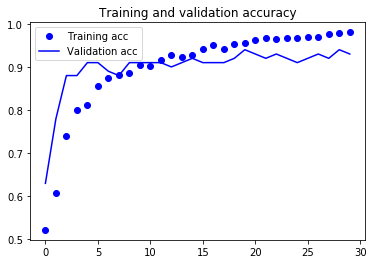

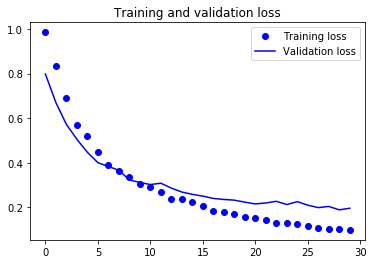

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [34]:
# save model weights
model.save_weights('/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/github_repo/Masters_Thesis/model_weights/'+'weights_for_vgg_model_with_new_fully_connected_layer')

In [8]:
# Now I just want to print my predictions
# We first need to pipe my new image through the conv_base to get the features which are inputs to my model 
# Note that the shape is also important since the last layer of the conv_base block5_pool produces an output 
# of shape (None, 4, 4, 512)).  Then we'll actually convert this to a two-dimensional array of shape (None, 4 * 4 * 512)) 
# This will be the input for the first fully connected layer. 

# https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

 
# RC: I needed to find out what shape the argument to conv_base.predict() is (i.e. inputs_batch which are the elements of generator)
# since I needed to supply my test images to the conv_base.predict() in the same fashion as previously so that they could run through 
# the base model and output the feature weights which I need to then supply to my new fully connected model.  It turns out that inputs_batch in 
# generator from flow_from_directory is a 2 dimensional tuple.  Both the first and second elements (0 and 1 indexed items) are ndarrays.  
# The shape of the first ndarray is (1, 150, 150, 3).  The shape of the second ndarray is (1,1) where the first element is just: [1.].  
# The second element is nothing.  

Found 16 images belonging to 1 classes.
<class 'numpy.ndarray'>
[[[[0.654902   0.7607844  0.93725497]
   [0.5568628  0.654902   0.86666673]
   [0.65882355 0.77647066 1.        ]
   ...
   [0.21568629 0.21568629 0.20784315]
   [0.20392159 0.21568629 0.14117648]
   [0.3647059  0.38823533 0.2784314 ]]

  [[0.63529414 0.7411765  0.9176471 ]
   [0.6392157  0.7372549  0.9490197 ]
   [0.57254905 0.6901961  0.92549026]
   ...
   [0.15686275 0.20000002 0.21568629]
   [0.         0.03529412 0.        ]
   [0.3921569  0.42352945 0.27058825]]

  [[0.6392157  0.74509805 0.9215687 ]
   [0.6313726  0.7294118  0.94117653]
   [0.4901961  0.60784316 0.8431373 ]
   ...
   [0.38431376 0.41176474 0.48627454]
   [0.33333334 0.3803922  0.3254902 ]
   [0.17254902 0.20392159 0.05882353]]

  ...

  [[0.6666667  0.49803925 0.47058827]
   [0.70980394 0.5764706  0.57254905]
   [0.64705884 0.47058827 0.48235297]
   ...
   [0.7960785  0.56078434 0.5568628 ]
   [0.6745098  0.45098042 0.4156863 ]
   [0.75294125 0.4705

In [9]:
RC_raw_images.shape

(16, 150, 150, 3)

In [94]:
test_features.shape

(6, 4, 4, 512)

In [95]:
test_features

array([[[[3.67666423e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 6.92035496e-01, 0.00000000e+00],
         [5.71552634e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 5.56001306e-01, 0.00000000e+00],
         [8.87130737e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.02411938e+00, 0.00000000e+00],
         [1.38021290e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.00360465e+00, 0.00000000e+00]],

        [[3.36002916e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 1.00881696e+00, 0.00000000e+00],
         [9.52552497e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 5.60572982e-01, 0.00000000e+00],
         [3.78653049e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 9.32006478e-01, 0.00000000e+00],
         [8.44109714e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 8.87677133e-01, 0.00000000e+00]],

        [[2.74821758

In [58]:
# RC: To load our model again (in case this is the starting point) we need to re-build our existing model: 

# RC: change the working directory 
#os.chdir('/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/github_repo/Masters_Thesis/model_weights/')
#!pwd
trained_weights_dir = os.path.join(base_dir, 'github_repo/Masters_Thesis/model_weights/')

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

# RC: function to rebuild my model again:
def rebuild_my_model():
    model = models.Sequential()
    #RC: where does the 256 come from?? I know it's the number of hidden units but is it specific to something?
    model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    model.add(layers.Dropout(0.5))
    #RC: changed the below so that the dense layer outputs probabilities for three classes
    #RC: also, changed activation='sigmoid' to activation='softmax'
    model.add(layers.Dense(3, activation='softmax'))
    
    model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    #RC: change the loss to categorical_crossentropy or sparse_categorical_crossentropy for my multi-class problem?
    loss='categorical_crossentropy',
    metrics=['acc'])
    return model

In [206]:
print (trained_weights_dir)

/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/github_repo/Masters_Thesis/model_weights/


In [62]:
model = rebuild_my_model()

In [63]:
print(model)

In [64]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


In [210]:
trained_weights_dir

'/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/github_repo/Masters_Thesis/model_weights/'

In [211]:
model.load_weights(trained_weights_dir + 'weights_for_vgg_model_with_new_fully_connected_layer')

In [46]:
test_features.shape

(6, 4, 4, 512)

In [96]:
# RC: reshape my feature tensor...
#RC: do I really have to flatten this out in order to use model.predict?  In 3.4.5 Chollet just feeds x_test to predict and xtest wasn't flattened... 
img_tensor = np.reshape(test_features, (6, 4 * 4 * 512))

In [97]:
img_tensor.shape

(6, 8192)

In [98]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2,098,179
Trainable params: 2,098,179
Non-trainable params: 0
_________________________________________________________________


In [99]:
results = model.predict(img_tensor)

In [100]:
print(results)

[[0.01124173 0.00464189 0.00048823]
 [0.00593999 0.12490416 0.00040169]
 [0.00127004 0.00115858 0.03288223]
 [0.00574961 0.01220488 0.00033404]
 [0.00032287 0.00156241 0.00113994]
 [0.00207904 0.02519111 0.00073803]]


In [103]:
label_map

{'Denver_Squares': 0, 'contemporary': 1, 'victorians': 2}

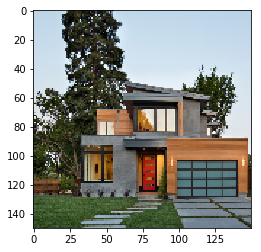

In [110]:
index = 5
plt.imshow(RC_raw_test_images_to_print[index])
plt.show()
#print ("y = " + str(np.squeeze(RC_raw_images[:, index])))

In [37]:
RC_raw_images[3,125,125,]

array([0.34117648, 0.4784314 , 0.50196081])

In [71]:
#https://towardsdatascience.com/whats-that-image-fb6ab703c4a5from keras.applications.vgg16 import decode_predictions
label = decode_predictions(results)
print(label)

ValueError: `decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: (6, 3)

In [57]:
#RC: I'd like to use a combination of the below, but I'm not sure what the feature dimensions are when they actually use flow_from_directory BEFORE using conv_base to predict and get the out putput which we'd then need to convert to the 2 dimensional matrix
from keras.preprocessing import image

def load_image(test_dir, show=False):

    img = image.load_img(test_dir, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
 

load_image(test_dir+'hidden_classes/test 2.jpg')

In [201]:

print(features_batch)
print(features_batch.shape)

#RC: After we pipe in through the conv_base, we need to add this line to convert to a two dimensional array
re_shaped_img_tensor = np.reshape(features_batch, (1, 4 * 4 * 512))

#RC: use our model containing the fully connected dense classification layer to serve our predictions
model.predict(re_shaped_img_tensor)



[[[[0.39321703 0.         0.         ... 0.         0.44950604
    0.        ]
   [0.66083187 0.         0.         ... 0.         0.
    0.        ]
   [0.86983895 0.         0.         ... 0.         0.
    0.        ]
   [0.2916637  0.         0.         ... 0.         0.
    0.        ]]

  [[0.49590904 0.         0.         ... 0.         0.9443723
    0.        ]
   [0.5702241  0.         0.         ... 0.         0.5729468
    0.        ]
   [0.11124131 0.         0.         ... 0.         0.08119887
    0.        ]
   [0.7263701  0.         0.         ... 0.         0.31839642
    0.        ]]

  [[0.4746732  0.         0.09706274 ... 0.         1.2202439
    0.        ]
   [1.0607734  0.         0.04258046 ... 0.         0.7524153
    0.        ]
   [0.929091   0.         0.         ... 0.         0.24107721
    0.        ]
   [1.4596096  0.         0.         ... 0.         0.51516366
    0.        ]]

  [[0.57345027 0.         0.15884078 ... 0.         0.66196465
    0.     

array([[0.00325804, 0.00171638, 0.06686961]], dtype=float32)

In [ ]:


from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    #model = load_model("model_aug.h5")

    # image path
    img_path = '/Users/rchase/Documents/Ryan Chase Deloitte Files/M.S/PRED_590 - Masters Thesis/Images/architecture_styles/test/test6.jpg'    # dog
    #img_path = '/media/data/dogscats/test1/19.jpg'      # cat

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)


In [45]:
img_tensor.shape

(1, 150, 150, 3)


We reach a validation accuracy of about 90%, much better than what we could achieve in the previous section with our small model trained from 
scratch. However, our plots also indicate that we are overfitting almost from the start -- despite using dropout with a fairly large rate. 
This is because this technique does not leverage data augmentation, which is essential to preventing overfitting with small image datasets.

Now, let's review the second technique we mentioned for doing feature extraction, which is much slower and more expensive, but which allows 
us to leverage data augmentation during training: extending the `conv_base` model and running it end-to-end on the inputs. Note that this 
technique is in fact so expensive that you should only attempt it if you have access to a GPU: it is absolutely intractable on CPU. If you 
cannot run your code on GPU, then the previous technique is the way to go.

Because models behave just like layers, you can add a model (like our `conv_base`) to a `Sequential` model just like you would add a layer. 
So you can do the following:

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

This is what our model looks like now:

In [ ]:
model.summary()

As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 2 
million parameters.

Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of 
layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were 
previously learned by the convolutional base would get modified during training. Since the `Dense` layers on top are randomly initialized, 
very large weight updates would be propagated through the network, effectively destroying the representations previously learned.

In Keras, freezing a network is done by setting its `trainable` attribute to `False`:

In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

With this setup, only the weights from the two `Dense` layers that we added will be trained. That's a total of four weight tensors: two per 
layer (the main weight matrix and the bias vector). Note that in order for these changes to take effect, we must first compile the model. 
If you ever modify weight trainability after compilation, you should then re-compile the model, or these changes would be ignored.

Now we can start training our model, with the same data augmentation configuration that we used in our previous example:

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20
        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

In [ ]:
model.save('cats_and_dogs_small_3.h5')

Let's plot our results again:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

As you can see, we reach a validation accuracy of about 96%. This is much better than our small convnet trained from scratch.

## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [ ]:
conv_base.summary()


We will fine-tune the last 3 convolutional layers, which means that all layers up until `block4_pool` should be frozen, and the layers 
`block5_conv1`, `block5_conv2` and `block5_conv3` should be trainable.

Why not fine-tune more layers? Why not fine-tune the entire convolutional base? We could. However, we need to consider that:

* Earlier layers in the convolutional base encode more generic, reusable features, while layers higher up encode more specialized features. It is 
more useful to fine-tune the more specialized features, as these are the ones that need to be repurposed on our new problem. There would 
be fast-decreasing returns in fine-tuning lower layers.
* The more parameters we are training, the more we are at risk of overfitting. The convolutional base has 15M parameters, so it would be 
risky to attempt to train it on our small dataset.

Thus, in our situation, it is a good strategy to only fine-tune the top 2 to 3 layers in the convolutional base.

Let's set this up, starting from where we left off in the previous example:

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

Now we can start fine-tuning our network. We will do this with the RMSprop optimizer, using a very low learning rate. The reason for using 
a low learning rate is that we want to limit the magnitude of the modifications we make to the representations of the 3 layers that we are 
fine-tuning. Updates that are too large may harm these representations.

Now let's proceed with fine-tuning:

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_4.h5')

Let's plot our results using the same plotting code as before:

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look very noisy. To make them more readable, we can smooth them by replacing every loss and accuracy with exponential moving 
averages of these quantities. Here's a trivial utility function to do this:

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


These curves look much cleaner and more stable. We are seeing a nice 1% absolute improvement.

Note that the loss curve does not show any real improvement (in fact, it is deteriorating). You may wonder, how could accuracy improve if the 
loss isn't decreasing? The answer is simple: what we display is an average of pointwise loss values, but what actually matters for accuracy 
is the distribution of the loss values, not their average, since accuracy is the result of a binary thresholding of the class probability 
predicted by the model. The model may still be improving even if this isn't reflected in the average loss.

We can now finally evaluate this model on the test data:

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)


Here we get a test accuracy of 97%. In the original Kaggle competition around this dataset, this would have been one of the top results. 
However, using modern deep learning techniques, we managed to reach this result using only a very small fraction of the training data 
available (about 10%). There is a huge difference between being able to train on 20,000 samples compared to 2,000 samples!

## Take-aways: using convnets with small datasets

Here's what you should take away from the exercises of these past two sections:

* Convnets are the best type of machine learning models for computer vision tasks. It is possible to train one from scratch even on a very 
small dataset, with decent results.
* On a small dataset, overfitting will be the main issue. Data augmentation is a powerful way to fight overfitting when working with image 
data.
* It is easy to reuse an existing convnet on a new dataset, via feature extraction. This is a very valuable technique for working with 
small image datasets.
* As a complement to feature extraction, one may use fine-tuning, which adapts to a new problem some of the representations previously 
learned by an existing model. This pushes performance a bit further.

Now you have a solid set of tools for dealing with image classification problems, in particular with small datasets.